## 教師あり学習でLQRエージェントを再現する

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr
import gym2
from rl2.agents import selfDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def gain(dt=None):
    m, l, g = env.m, env.l, env.g

    A = np.array([[0, 1], [(3*g)/(2*l), 0]])
    B = np.array([[0], [3/(m*l**2)]])
    Q = np.array([[1, 0], [0, 0.1]])
    R = np.array([[0.001]])
    
    if dt is not None:
        Ad, Bd = discretized_system(A, B, dt)  
        K = dlqr(Ad,Bd,Q,R)[0]
    else:
        K = lqr(A,B,Q,R)[0]
    
    return K

def model(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(2, activation="self_trigger_output")(x)
    model = Model(inputs=action_input, outputs=x)
    return model

In [4]:
NN = model((2,),(2,))

In [5]:
# 学習データの用意
tau = 0.001
action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
dt = tau / action_repetition
print(dt)
K = gain(dt)
x_train = []
y_train = []
for i in range(30000):
    x_train.append([np.random.randn(2,) / 16.])
    y_train.append([np.dot(K, x_train[-1][0]), tau])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape, y_train.shape)

0.001
(30000, 1, 2) (30000, 2)


In [6]:
# learn
NN.compile(loss='mean_squared_error',optimizer='adam')
history = NN.fit(x_train, y_train, batch_size=128, epochs=150, verbose=0)

In [7]:
# save
NN.save_weights('./saved_agent/self_trigger.h5')

## 学習したNNを, actorにloadする

In [8]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(2, activation="self_trigger_output")(x)
    actor = Model(inputs=action_input, outputs=x)
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

In [9]:
# loading
a = agent((2,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
a.actor.load_weights('./saved_agent/self_trigger.h5')

NN: -2.0712409019470215, opt: -2.082422571911649
NN: -3.0090010166168213, opt: -3.0492488688273687
NN: 1.6264903545379639, opt: 1.607856728096202
NN: -1.604936122894287, opt: -1.6057690238321283
NN: 4.852119445800781, opt: 4.853168691838391
NN: -0.7504492998123169, opt: -0.747612878359277
NN: 2.351412534713745, opt: 2.355543137191339
NN: 1.4717941284179688, opt: 1.4524757324803872
NN: 2.764392137527466, opt: 2.788995163159177
NN: -4.143153190612793, opt: -4.134597856414923
NN: 0.8932702541351318, opt: 0.8732490764076781
NN: -2.4365601539611816, opt: -2.463152067837677
NN: -2.0098955631256104, opt: -2.0185018224478
NN: -0.6785228252410889, opt: -0.6791440995903625
NN: 6.947216033935547, opt: 6.923202436634518
NN: 1.7485159635543823, opt: 1.731922442614427
NN: 1.4377270936965942, opt: 1.4206245031561322
NN: -2.1121957302093506, opt: -2.1247950835579257
NN: 0.7151380181312561, opt: 0.6983575281559523
NN: 0.23675628006458282, opt: 0.2227409701014973
NN: -3.014441728591919, opt: -3.05232006

NN: 3.9025468826293945, opt: 3.8689871769464474
NN: -4.849291801452637, opt: -4.874753934740406
NN: -1.218317985534668, opt: -1.216334836593072
NN: -1.5336337089538574, opt: -1.5341546876095125
NN: 0.1780564785003662, opt: 0.1636535776506729
NN: 0.5741517543792725, opt: 0.5578401905788091
NN: 1.2227128744125366, opt: 1.2012326399668667
NN: 0.8091927766799927, opt: 0.7920413339123478
NN: 2.4747560024261475, opt: 2.482094820642537
NN: 0.278469443321228, opt: 0.2646083407160253
NN: 1.4149771928787231, opt: 1.3945828935407583
NN: -2.5021564960479736, opt: -2.5309071714017506
NN: -2.8641037940979004, opt: -2.9143828842111965
NN: 1.1855162382125854, opt: 1.1629974581170204
NN: -4.5477423667907715, opt: -4.550716637936721
NN: 3.5961053371429443, opt: 3.576035234157266
NN: 2.6217384338378906, opt: 2.6365356650719005
NN: 3.08746600151062, opt: 3.095136162918589
NN: 0.6199679374694824, opt: 0.6020837722190648
NN: 4.955900192260742, opt: 4.958305005263702
NN: -0.7238782048225403, opt: -0.72640469

NN: -0.2938821315765381, opt: -0.29941881586337415
NN: 5.231035232543945, opt: 5.263831067598288
NN: -3.120612621307373, opt: -3.151498630857782
NN: 3.953399896621704, opt: 3.9232826557017906
NN: -1.6827843189239502, opt: -1.684362842332427
NN: -0.5902748703956604, opt: -0.5913632236422008
NN: -1.8592311143875122, opt: -1.862790146805335
NN: 1.2501544952392578, opt: 1.2308814474167062
NN: 2.4476120471954346, opt: 2.451700230606278
NN: -3.4598934650421143, opt: -3.46521588777217
NN: 1.396928071975708, opt: 1.377058806512967
NN: -0.8248385190963745, opt: -0.8235047363168431
NN: 5.5122175216674805, opt: 5.598429087814184
NN: 1.2048743963241577, opt: 1.1820559639651356
NN: -0.49458202719688416, opt: -0.49765821980028624
NN: -2.1370415687561035, opt: -2.1487531133979827
NN: 1.1456718444824219, opt: 1.123937637342344
NN: 2.764552593231201, opt: 2.787547287243033
NN: 1.0945866107940674, opt: 1.0748006237998673
NN: 2.383080244064331, opt: 2.3881121757600345
NN: -0.8005812168121338, opt: -0.801

NN: 4.132120132446289, opt: 4.094869639822267
NN: 0.592326283454895, opt: 0.572585138012963
NN: -2.225260019302368, opt: -2.240518951066037
NN: 2.004833459854126, opt: 1.995952959035753
NN: 0.5135449767112732, opt: 0.49525369997483004
NN: -1.314439296722412, opt: -1.3114706779881569
NN: 0.31793370842933655, opt: 0.30208416920884085
NN: -0.15306144952774048, opt: -0.16105167213172042
NN: 0.5459147095680237, opt: 0.5305218219415689
NN: 4.043438911437988, opt: 4.00819898422297
NN: -0.9680413007736206, opt: -0.9675500791732128
NN: -1.6522696018218994, opt: -1.6544001892024645
NN: -2.784691095352173, opt: -2.8296025639465388
NN: 1.8775389194488525, opt: 1.8625494303631944
NN: -1.8000234365463257, opt: -1.8056327931932612
NN: 3.6484971046447754, opt: 3.626427933278338
NN: 1.190446376800537, opt: 1.1686806660081257
NN: -0.748874306678772, opt: -0.7503208164169971
NN: -4.851370811462402, opt: -4.873775227958383
NN: 1.9174121618270874, opt: 1.9056306005043202
NN: 0.4560980796813965, opt: 0.4398

NN: -4.530840873718262, opt: -4.534197948211109
NN: -2.2971549034118652, opt: -2.3167204948443154
NN: -0.5476305484771729, opt: -0.5506514217209368
NN: 1.0795483589172363, opt: 1.058833367181821
NN: 1.7450584173202515, opt: 1.7301623369764672
NN: -2.7372589111328125, opt: -2.780171326774254
NN: -1.6078157424926758, opt: -1.612299518474165
NN: -2.3221116065979004, opt: -2.3414045050507206
NN: -2.068141460418701, opt: -2.078567525249239
NN: -2.6407907009124756, opt: -2.6742463289794385
NN: 0.20286840200424194, opt: 0.1909533799913409
NN: -3.082442045211792, opt: -3.1153172693490925
NN: -0.6621639728546143, opt: -0.6633963407513495
NN: 2.441202163696289, opt: 2.446225343339215
NN: 0.9922805428504944, opt: 0.9738510294922473
NN: -0.4553338885307312, opt: -0.4608531313622266
NN: -2.351637840270996, opt: -2.368980136309905
NN: -1.9977593421936035, opt: -2.0075124384925735
NN: 1.2285568714141846, opt: 1.208554697552813
NN: -0.6212135553359985, opt: -0.6209313739980652
NN: -2.6556050777435303,

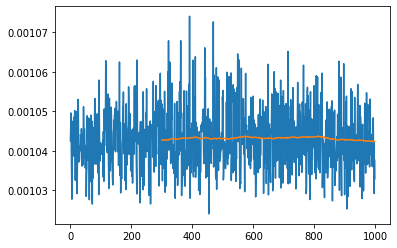

In [10]:
# validation
taus = []
for i in range(1000):
    x = np.random.randn(2,) / 16.
    a_agent, tau = a.forward(x)
    taus.append(tau)
    print(f'NN: {a_agent}, opt: {np.dot(K, x)}')
plt.plot(range(len(taus)), taus)
plt.plot(range(300, len(taus)), moving_average(taus, 300))
plt.show()

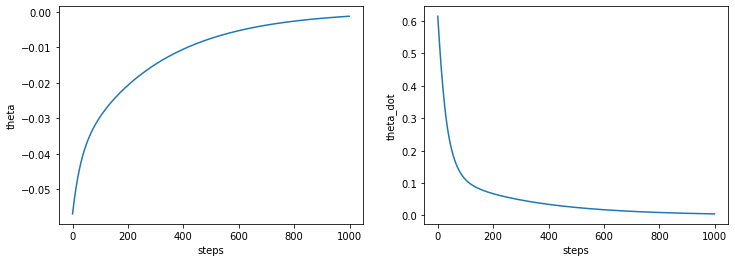

In [11]:
# 実環境テスト

def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= np.pi
    th = np.sign(th) * r
    return th

env.reset()
states = []
for i in range(1000):
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    a_agent, tau = a.forward(x)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,_,_ = env.step(np.array([a_agent]), dt, tau)
states = np.array(states)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(range(states.shape[0]), states[:,0])
plt.subplot(1,2,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(range(states.shape[0]), states[:,1])
plt.show()

In [12]:
print(taus)

[0.0010425831, 0.0010457421, 0.001049583, 0.0010398478, 0.0010338407, 0.0010277797, 0.0010350437, 0.0010441113, 0.0010474893, 0.0010403538, 0.0010460395, 0.0010485402, 0.0010386771, 0.0010393295, 0.0010501835, 0.0010485025, 0.0010325705, 0.0010432639, 0.0010362462, 0.0010499334, 0.0010377031, 0.0010489082, 0.0010291826, 0.0010377511, 0.0010437286, 0.0010529995, 0.0010510295, 0.0010371994, 0.0010394077, 0.0010372814, 0.0010383078, 0.0010411182, 0.0010400226, 0.0010440863, 0.0010436779, 0.0010423484, 0.00104558, 0.0010440396, 0.0010361451, 0.001044112, 0.001040708, 0.0010364108, 0.0010443379, 0.0010511626, 0.0010457353, 0.0010381525, 0.0010456392, 0.0010423155, 0.0010407828, 0.0010356996, 0.0010411631, 0.0010399219, 0.0010284946, 0.0010340464, 0.0010355538, 0.0010488707, 0.0010420845, 0.0010376833, 0.001045907, 0.0010483189, 0.0010382467, 0.0010453665, 0.001027647, 0.0010480711, 0.0010368463, 0.0010321949, 0.0010407391, 0.0010490449, 0.0010378386, 0.0010417438, 0.0010475483, 0.001027638,

## サンプル値系の初期エージェントの学習

In [14]:
def gain(dt=None):
    m, l, g = env.m, env.l, env.g

    A = np.array([[0, 1], [(3*g)/(2*l), 0]])
    B = np.array([[0], [3/(m*l**2)]])
    Q = np.array([[1, 0], [0, 0.1]])
    R = np.array([[0.001]])
    
    if dt is not None:
        Ad, Bd = discretized_system(A, B, dt)  
        K = dlqr(Ad,Bd,Q,R)[0]
    else:
        K = lqr(A,B,Q,R)[0]
    
    return K

def model(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="multiple_tanh")(x)
    model = Model(inputs=action_input, outputs=x)
    return model

In [15]:
NN = model((1,),(2,))

In [16]:
# 学習データの用意
tau = 0.001
action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
dt = tau / action_repetition
print(dt)
K = gain(dt)
x_train = []
y_train = []
for i in range(30000):
    x_train.append([np.random.randn(2,) / 16.])
    y_train.append([np.dot(K, x_train[-1][0])])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape, y_train.shape)

0.001
(30000, 1, 2) (30000, 1)


In [17]:
# learn
NN.compile(loss='mean_squared_error',optimizer='adam')
history = NN.fit(x_train, y_train, batch_size=128, epochs=50, verbose=0)

In [18]:
# save
NN.save_weights('./saved_agent/sample_value.h5')